imports

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import scipy.stats as scs
import os
import geopandas as gpd
from sklearn.metrics.pairwise import haversine_distances
import math


plt.style.use('fivethirtyeight')

In [2]:
import warnings
warnings.filterwarnings(action='ignore')

In [3]:
def get_csv(chamber, congress):
    fpath = '../congress-data/%s/%s_%d.csv' % (chamber, chamber, congress)
    cong_df = pd.read_csv(fpath, index_col=0)
    cong_df = cong_df.reset_index()
    
    cong_df['PCT'] = cong_df['missed_votes'] / cong_df['total_votes']
    
    if chamber == 'house':
        inds = cong_df['at_large'] == True
        cong_df.loc[inds, 'district'] = '0'
    
    return cong_df

def get_shapefile(chamber, congress):
    if chamber == 'house' and congress < 115:
        fpath = '../congress-data/shapefiles/districtShapes%d/districts%d.shp' % (congress, congress)
        map_df = gpd.read_file(fpath)
    elif chamber == 'house' and congress == 115:
        fpath = '../congress-data/shapefiles/cb_2016_us_cd115_500k/cb_2016_us_cd115_500k.shp'
        districts = gpd.read_file(fpath)  
        
        fpath = '../congress-data/shapefiles/cb_2018_us_state_500k/cb_2018_us_state_500k.shp'
        states = gpd.read_file(fpath) 
        
        map_df = states[['STATEFP', 'NAME']].merge(districts, how='inner', left_on='STATEFP', right_on='STATEFP')
        
        map_df = gpd.GeoDataFrame(map_df)
        
        map_df['STATENAME'] = map_df['NAME']
        map_df['DISTRICT'] = map_df['CD115FP']

    elif chamber == 'house' and congress == 116:
        fpath = '../congress-data/shapefiles/cb_2018_us_cd116_500k/cb_2018_us_cd116_500k.shp'
        districts = gpd.read_file(fpath)    
        
        fpath = '../congress-data/shapefiles/cb_2018_us_state_500k/cb_2018_us_state_500k.shp'
        states = gpd.read_file(fpath)
        
        map_df = states[['STATEFP', 'NAME']].merge(districts, how='inner', left_on='STATEFP', right_on='STATEFP')
        
        map_df = gpd.GeoDataFrame(map_df)

        map_df['STATENAME'] = map_df['NAME']
        map_df['DISTRICT'] = map_df['CD116FP']
    else:
        fpath = '../congress-data/shapefiles/cb_2018_us_state_500k/cb_2018_us_state_500k.shp'
        map_df = gpd.read_file(fpath)    
        map_df['STATENAME'] = map_df['NAME']
        
    return map_df

def get_merged_df(chamber, congress):
    map_df = get_shapefile(chamber, congress)
    cong_df = get_csv(chamber, congress)
    
    if chamber == 'house':
        left_on = ['STATENAME', 'DISTRICT']
        right_on = ['state_names', 'district']
    else:
        left_on = ['STATENAME']
        right_on = ['state_names']
    
    merged = map_df.merge(cong_df, how='inner', left_on=left_on, right_on=right_on)

    return merged

## Data Exploration
Why do Representatives miss votes?

### Quantitative Variables:
    - age
    - seniority
    - distance from D.C.
### Qualitative Variables:
    - gender
    - party
    - region of country
    



In [4]:
get_csv('house', 115)

,index,id,first_name,last_name,dob,gender,party,leadership_role,govtrack_id,cspan_id,seniority,total_votes,missed_votes,total_present,state,district,at_large,geoid,state_names,PCT
0,0,A000374,Ralph,Abraham,1954-09-16,M,R,False,412630.0,76236.0,4,1210,18.0,0.0,LA,5,False,2205,Louisiana,0.014876
1,1,A000370,Alma,Adams,1946-05-27,F,D,False,412607.0,76386.0,6,1210,32.0,2.0,NC,12,False,3712,North Carolina,0.026446
2,2,A000055,Robert,Aderholt,1965-07-22,M,R,False,400004.0,45516.0,22,1210,50.0,0.0,AL,4,False,104,Alabama,0.041322
3,3,A000371,Pete,Aguilar,1979-06-19,M,D,False,412615.0,79994.0,4,1210,14.0,2.0,CA,31,False,631,California,0.011570
4,4,A000372,Rick,Allen,1951-11-07,M,R,False,412625.0,62545.0,4,1210,16.0,0.0,GA,12,False,1312,Georgia,0.013223
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445,451,Y000065,Ted,Yoho,1955-04-13,M,R,False,412525.0,63943.0,6,1210,47.0,0.0,FL,3,False,1203,Florida,0.038843
446,452,Y000033,Don,Young,1933-06-09,M,R,False,400440.0,1897.0,46,1210,44.0,0.0,AK,0,True,200,Alaska,0.036364
447,453,Y000066,David,Young,1968-05-11,M,R,False,412628.0,76211.0,4,1210,0.0,0.0,IA,3,False,1903,Iowa,0.000000
448,454,Z000017,Lee,Zeldin,1980-01-30,M,R,False,412646.0,61616.0,4,1210,35.0,0.0,NY,1,False,3601,New York,0.028926


In [49]:
def chamber_5_num_sum(chamber):
    total_votes = []
    missed_votes = []
    for session in range(102, 117):
        df = get_csv(chamber, session)
        
        total_votes.append(df.loc[0]['total_votes'])
        missed_votes.extend(df['missed_votes'])
        
    total_q = np.percentile(total_votes, [25, 50, 75])
    missed_q = np.percentile(missed_votes, [25, 50, 75])
    
    total_min = np.min(total_votes)
    missed_min = np.min(missed_votes)
    
    total_max = np.max(total_votes)
    missed_max = np.max(missed_votes)
    
    print('5 number summary for: The %s' % (chamber.capitalize()))
    print('102nd Congress - 116th Congress')
    print('    | Total Votes | Missed Votes')
    print('Min:|    %d    |    %d' % (total_min, missed_min))
    print('Q1: |    %d    |    %d' % (total_q[0], missed_q[0]))
    print('Med:|    %d    |    %d' % (total_q[1], missed_q[1]))
    print('Q3: |    %d    |    %d' % (total_q[2], missed_q[2]))
    print('Max:|    %d    |    %d' % (total_max, missed_max))
    print('\n')
    
    fig, ax = plt.subplots(1, 2, figsize=(10,5))
    ax[0].boxplot(total_votes)
    ax[1].boxplot(missed_votes)
    ax[0].set_title('Total Votes')
    ax[1].set_title('Missed Votes')
    

5 number summary for: The House
102nd Congress - 116th Congress
    | Total Votes | Missed Votes
Min:|    857    |    0
Q1: |    1154    |    17
Med:|    1214    |    35
Q3: |    1333    |    66
Max:|    1876    |    1695


5 number summary for: The Senate
102nd Congress - 116th Congress
    | Total Votes | Missed Votes
Min:|    486    |    0
Q1: |    582    |    4
Med:|    645    |    10
Q3: |    673    |    21
Max:|    919    |    488




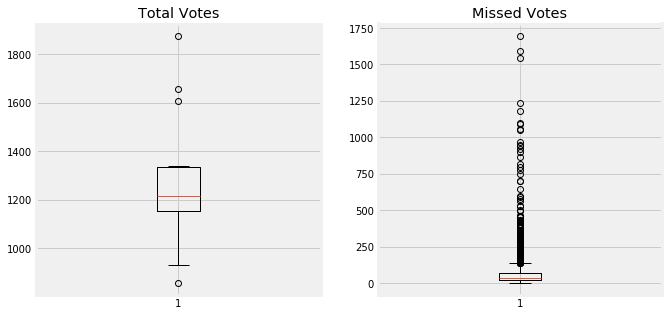

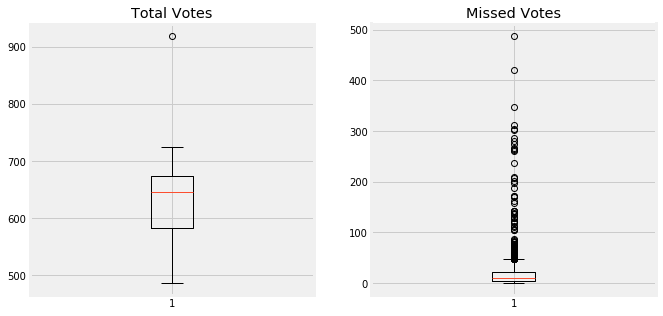

In [50]:
chamber_5_num_sum('house')
chamber_5_num_sum('senate')

### Five Number Summary For Each Chamber

```
5 number summary for: The House
102nd Congress - 116th Congress
===============================
    | Total Votes | Missed Votes
Min:|     857     |     0
Q1: |     1154    |     17
Med:|     1214    |     35
Q3: |     1333    |     66
Max:|     1876    |     1695


5 number summary for: The Senate
101st Congress - 116th Congress
================================
    | Total Votes | Missed Votes
Min:|     486     |      0
Q1: |     578     |      4
Med:|     645     |      10
Q3: |     673     |      21
Max:|     916     |      488
```

## The House of Representatives

### Age vs Missed Votes%
#### Current Congress

In [7]:
def create_datetime_obj(obj):
    datetime_obj = datetime.datetime.strptime(obj, '%Y-%m-%d')
    
    return datetime_obj

def get_age_votes_correlation(chamber, congress, plot=True):
    chamber_data = get_csv(chamber, congress)
    chamber_data = chamber_data.reset_index()
    chamber_data['dob'] = chamber_data['dob'].apply(create_datetime_obj)
    
    for i in range(len(chamber_data)):
        birthdate = chamber_data.loc[i]['dob'].date()
        today = datetime.date.today()
        difference = today - birthdate
        age = (difference.days + difference.seconds/86400)/365.2425

        chamber_data.loc[i, 'age'] = age
        
    ages = chamber_data['age']
    pcts = chamber_data['PCT']
    
    if plot:
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.scatter(ages, pcts)
        
        ax.set_xlabel('Age')
        ax.set_ylabel('Percentage of Missed Votes')
        ax.set_title('Age vs. Missed Vote %% for the %d %s' % (congress, chamber))
        
    return scs.pearsonr(ages, pcts)
    

(0.10567282413867662, 0.026311958128874532)

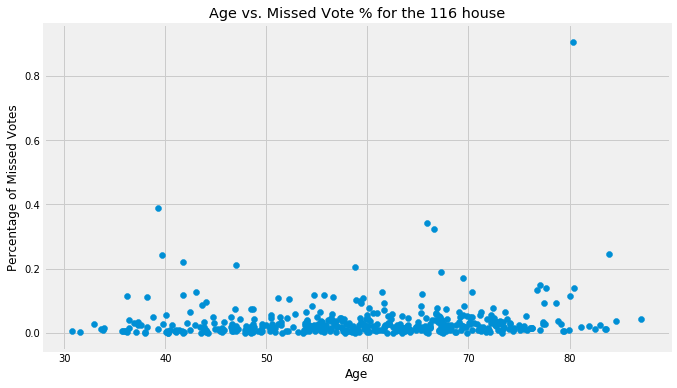

In [8]:
get_age_votes_correlation('house', 116)

(0.006353817381452215, 0.9497180253716784)

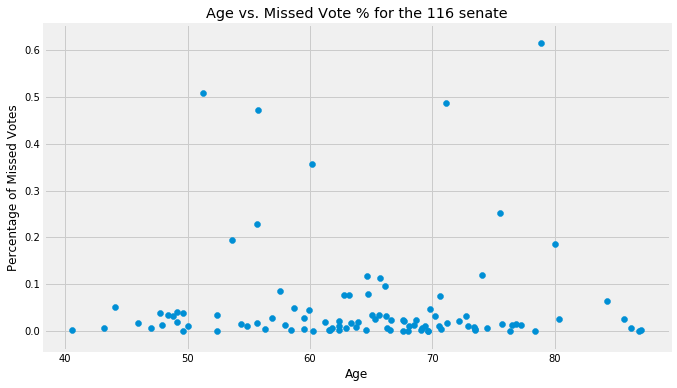

In [9]:
get_age_votes_correlation('senate', 116)

### Missed votes by session for house and senate

In [14]:
df = get_csv('senate', 116)
df = df[df['last_name'].isin(['Booker', 'Sanders', 'Harris', 'Warren', 'Klobuchar'])]
df

,index,id,first_name,last_name,dob,gender,party,leadership_role,govtrack_id,cspan_id,seniority,total_votes,missed_votes,total_present,state,senate_class,state_names,PCT
7,7,B001288,Cory,Booker,1969-04-27,M,D,False,412598,84679.0,7,565,287,1,NJ,2,New Jersey,0.507965
37,37,H001075,Kamala,Harris,1964-10-20,F,D,False,412678,1018696.0,1,565,266,1,CA,3,California,0.470796
51,51,K000367,Amy,Klobuchar,1960-05-25,F,D,Senate Democratic Steering Committee Chair,412242,83701.0,13,565,201,1,MN,1,Minnesota,0.355752
77,77,S000033,Bernard,Sanders,1941-09-08,M,ID,False,400357,994.0,13,565,347,1,VT,1,Vermont,0.614159
96,96,W000817,Elizabeth,Warren,1949-06-22,F,D,False,412542,1023023.0,7,565,275,1,MA,1,Massachusetts,0.486726


In [15]:
df = get_csv('senate', 114)
df = df[df['last_name'].isin(['Cruz', 'Rubio', 'Sanders'])]
df

,index,id,first_name,last_name,dob,gender,party,leadership_role,govtrack_id,cspan_id,seniority,total_votes,missed_votes,total_present,state,senate_class,state_names,PCT
26,26,C001098,Ted,Cruz,1970-12-22,M,R,False,412573,1019953,3,502,162,0,TX,1,Texas,0.322709
78,78,R000595,Marco,Rubio,1971-05-28,M,R,False,412491,87599,5,502,157,0,FL,3,Florida,0.312749
79,79,S000033,Bernard,Sanders,1941-09-08,M,ID,False,400357,994,9,502,143,0,VT,1,Vermont,0.284861


In [16]:
df = get_csv('senate', 110)
df = df[df['last_name'].isin(['Obama', 'Clinton', 'Edwards', 'McCain', 'Thompson'])]
df

,index,id,first_name,last_name,dob,gender,party,leadership_role,govtrack_id,cspan_id,seniority,total_votes,missed_votes,total_present,state,senate_class,state_names,PCT
21,21,C001041,Hillary,Clinton,1947-10-26,F,D,False,300022,NaN,7,657,208,0,NY,1,New York,0.316591
66,66,M000303,John,McCain,1936-08-29,M,R,False,300071,7476.0,21,657,420,0,AZ,3,Arizona,0.639269
75,75,O000167,Barack,Obama,1961-08-04,M,D,False,400629,NaN,3,657,303,0,IL,3,Illinois,0.461187


In [360]:
df = get_csv('senate', 108)
df = df[df['last_name'].isin(['Kerry', 'Edwards'])]
df

,index,id,first_name,last_name,dob,gender,party,leadership_role,govtrack_id,cspan_id,seniority,total_votes,missed_votes,total_present,state,senate_class,PCT,state_names
38,38,E000286,John,Edwards,1953-06-10,M,D,False,300039,NaN,5,675,305,0,NC,3,0.451852,North Carolina
59,59,K000148,John,Kerry,1943-12-11,M,D,False,300060,1485.0,19,675,488,0,MA,2,0.722963,Massachusetts


In [17]:
df = get_csv('senate', 106)
df = df[df['last_name'].isin(['Bradley', 'McCain'])]
df

,index,id,first_name,last_name,dob,gender,party,leadership_role,govtrack_id,cspan_id,seniority,total_votes,missed_votes,total_present,state,senate_class,state_names,PCT
70,70,M000303,John,McCain,1936-08-29,M,R,False,300071,7476.0,13,672,198,2,AZ,3,Arizona,0.294643


In [20]:
def plot_missed_votes_by_session(chamber):

    fig, ax = plt.subplots(figsize=(18, 10))

    if chamber=='senate':
        lower=101
    else:
        lower=102
    
    for session in range(lower, 117):
        if session == lower:
            total_label = 'Total Votes For Session'
            avg_label = 'Avg Missed Votes For Session'
            ind_label = 'Individual Votes For Session'
            
        else:
            total_label = ''
            avg_label = ''
            ind_label = ''
            
        data = get_csv(chamber, session)
        
        missed_votes = data['missed_votes']
        total_votes = data.loc[0]['total_votes']
        sessions = np.full((len(missed_votes),), session)
        avg = np.mean(missed_votes)
        ax.scatter(sessions, missed_votes, alpha=0.5, c='#90CAF9', label=ind_label)
        ax.scatter(session, avg, alpha=1, c='#EF9A9A', edgecolor='black', s=100, label=avg_label)
        ax.scatter(session, total_votes, alpha=1, c='#C5E1A5', edgecolor='black', s=100, label=total_label)
        
     
    if chamber == 'senate':
        candidates = [287, 266, 201, 247, 275, 162, 157, 143, 208, 420, 303, 305, 488, 198]
        cands = [116, 116, 116, 116, 116, 114, 114, 114, 110, 110, 110, 108, 108, 106]
        ax.scatter(cands, candidates,  c='#FFF59D', s=100, edgecolor='black', label='Presidential Candidates')
    ax.set_xlabel('Congressional Sessions')
    ax.set_ylabel('# of Missed Votes')
    ax.set_title('# of missed votes by session for the %s' % chamber)
    ax.legend()

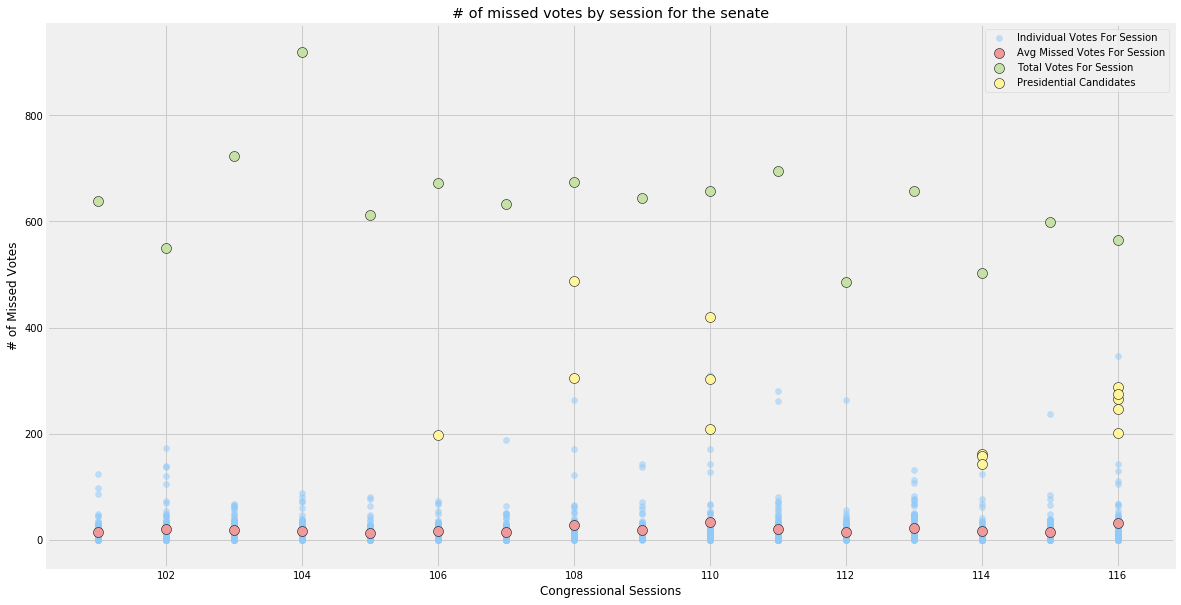

In [21]:
plot_missed_votes_by_session('senate')

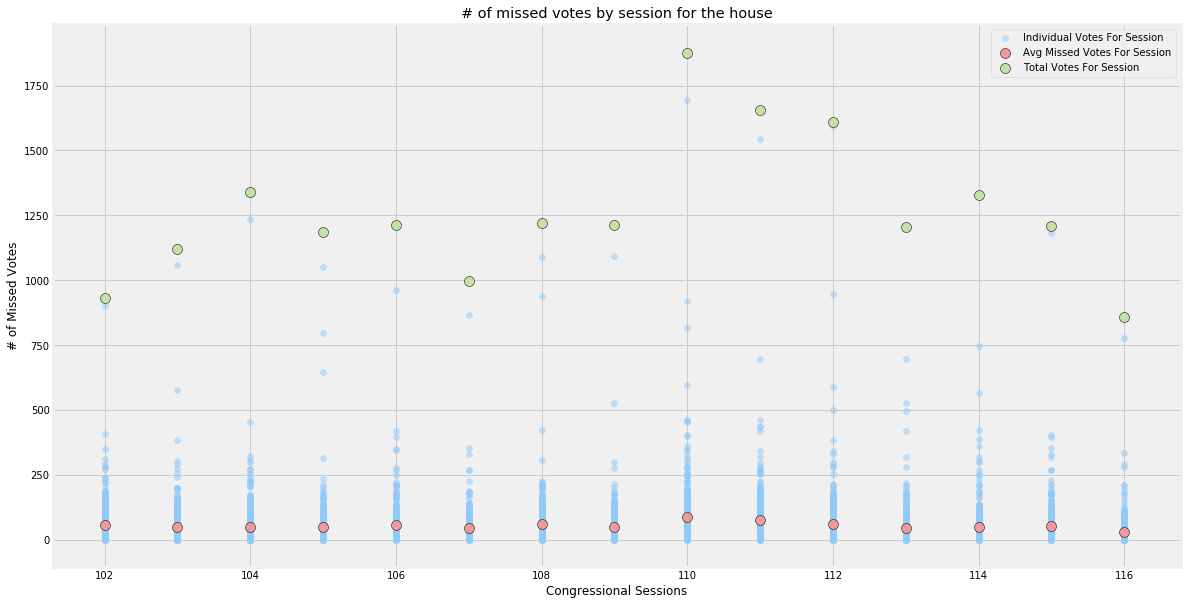

In [22]:
plot_missed_votes_by_session('house')

In [23]:
def plot_avgs_by_session():
    fig, ax = plt.subplots(figsize=(9, 6))

    for session in range(101, 117):
        if session != 101:
            house_data = get_csv('house', session)
            house_avg = np.mean(house_data['missed_votes']) / np.mean(house_data['total_votes'])
            house_label = 'House of Representatives' if session==102 else ''
            ax.scatter(session, house_avg, alpha=0.5, c='#AED581', edgecolor='black', s=50, label=house_label)
            
        senate_data = get_csv('senate', session)
        senate_avg = np.mean(senate_data['missed_votes']) / np.mean(senate_data['total_votes'])
        senate_label = 'Senate' if session==102 else ''
        ax.scatter(session, senate_avg, alpha=0.5, c='#FFF176', edgecolor='black', s=50, label=senate_label)
        
    ax.set_xlabel('Congressional Sessions')
    ax.set_ylabel('Average % of Missed Votes')
    ax.set_title('Average % of missed votes by session for both chambers')
    ax.set_ylim(-0.05, 1.05)
    ax.legend()

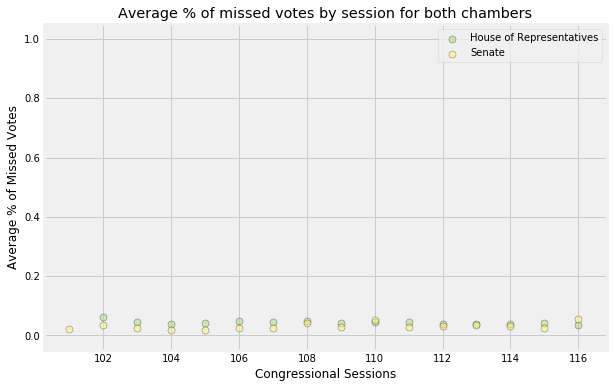

In [24]:
plot_avgs_by_session()

### Seniority vs Missed Votes

In [25]:
def plotting_seniority_against_missed_votes(chamber, congress, plot=True):
    chamber_data = get_csv(chamber, congress)
    chamber_data = chamber_data.reset_index()
        
    seniority = chamber_data['seniority']
    
    num_missed = chamber_data['missed_votes']
    
    if plot:
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.scatter(seniority, num_missed, c='#90CAF9', alpha=0.5)
        
        idx = chamber_data.groupby('seniority')['missed_votes'].mean().index
        means = chamber_data.groupby('seniority')['missed_votes'].mean().values
        
        ax.scatter(idx, means, alpha=1, c='#EF9A9A', edgecolor='black', s=50)
        
        ax.set_xlabel('Seniority')
        ax.set_ylabel('Number of Missed Votes')
        ax.set_title('Seniority vs. Missed Votes for the %d %s' % (congress, chamber))
        
    return scs.pearsonr(seniority, num_missed)

(0.14686015983349837, 0.0017861513952903496)

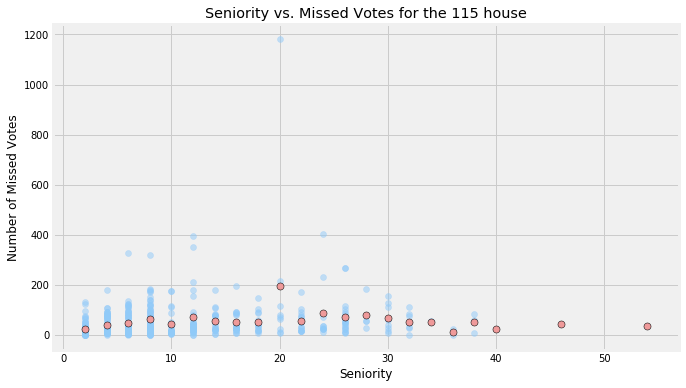

In [26]:
plotting_seniority_against_missed_votes('house', 115)

(0.2034900506559056, 0.037339800905145805)

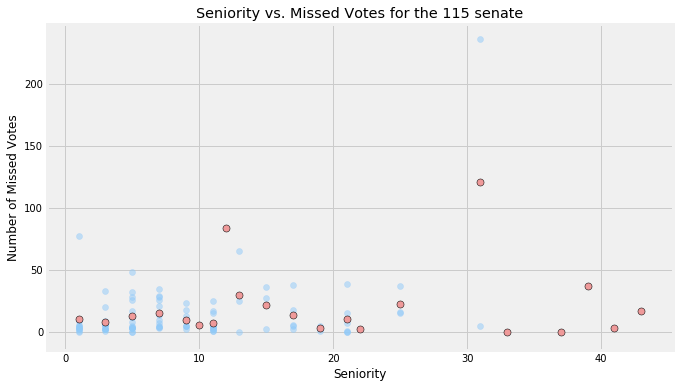

In [27]:
plotting_seniority_against_missed_votes('senate', 115)

In [28]:
def plotting_seniority_against_missed_votes_for_all_sessions(chamber):
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    for session in range(102, 117):
        chamber_data = get_csv(chamber, session)
        chamber_data = chamber_data.reset_index()

        idx = chamber_data.groupby('seniority')['missed_votes'].mean().index
        means = chamber_data.groupby('seniority')['missed_votes'].mean().values

        ax.scatter(idx, means, alpha=1, c='#EF9A9A', edgecolor='black', s=50)

        ax.set_xlabel('Seniority')
        ax.set_ylabel('Number of Missed Votes')
        ax.set_title('Seniority vs. Missed Votes for the %s' % (chamber))



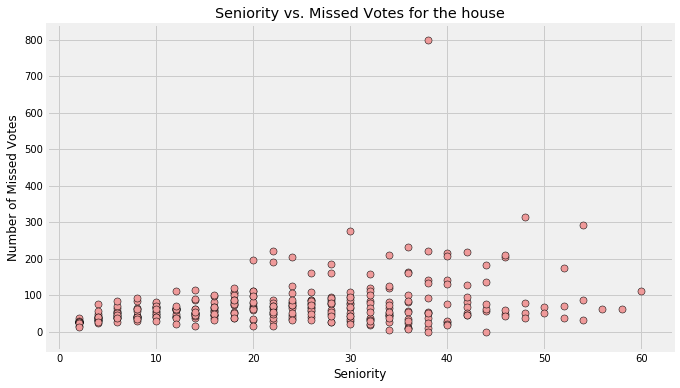

In [29]:
plotting_seniority_against_missed_votes_for_all_sessions('house')

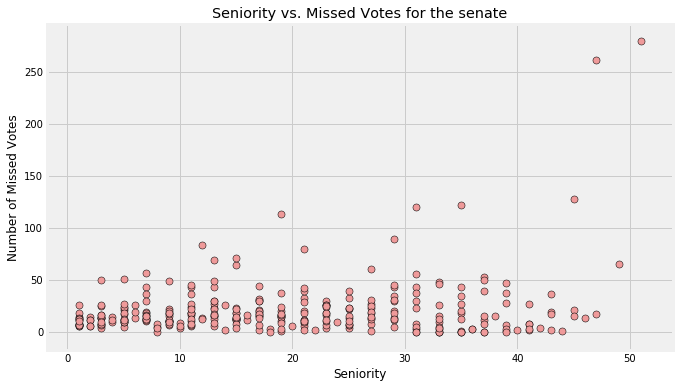

In [30]:
plotting_seniority_against_missed_votes_for_all_sessions('senate')

### Plotting Party VS Number of Missed Votes

In [31]:
def reps_vs_dems(chamber, method_of_center=np.mean):

    fig, ax = plt.subplots(figsize=(16,10))
    
    ax.axvspan(100, 103, color='#FFEBEE', alpha=0.5, label='Republican President')
    ax.axvspan(103, 107, color='#E3F2FD', alpha=0.5, label='Democratic President')
    ax.axvspan(107, 111, color='#FFEBEE', alpha=0.5)
    ax.axvspan(111, 115, color='#E3F2FD', alpha=0.5)
    ax.axvspan(115, 117, color='#FFEBEE', alpha=0.5)


    
    if chamber == 'house':
        lower = 102
    else:
        lower = 101

    for session in range(lower, 117):
        chamber_data = get_csv(chamber, session)
        
        rs = chamber_data[chamber_data['party'] == 'R']
        ds = chamber_data[chamber_data['party'] == 'D']
        
        r_avg = method_of_center(rs['missed_votes'])
        d_avg = method_of_center(ds['missed_votes'])
        
        r_missed = rs['missed_votes']
        d_missed = ds['missed_votes']
        
        if session == lower:
            r_label = 'Individual Republicans'
            r_avg_label = 'Avg. Republican'
            d_label = 'Individual Democrats'
            d_avg_label = 'Avg. Democrat'
        else:
            r_label = ''
            r_avg_label = ''
            d_label = ''
            d_avg_label = ''
        
        r_x = np.full((len(r_missed),), session)
        d_x = np.full((len(d_missed),), session)
        
        ax.scatter(r_x, r_missed, alpha=0.5, c='#EF9A9A', label=r_label)
        ax.scatter(d_x, d_missed, alpha=0.5, c='#90CAF9', label=d_label)
        
        ax.scatter(session, d_avg, alpha=1,c='#42A5F5',s=100,label=d_avg_label, edgecolor='black')
        ax.scatter(session, r_avg, alpha=1,c='#EF5350',s=100,label=r_avg_label, edgecolor='black')
        
    ax.set_xlabel('Congressional Sessions')
    ax.set_ylabel('# of Missed Votes')
    ax.set_title('# of missed votes by party - %s' % (chamber))
    
    ax.legend(framealpha=1, facecolor='white', loc='upper right')


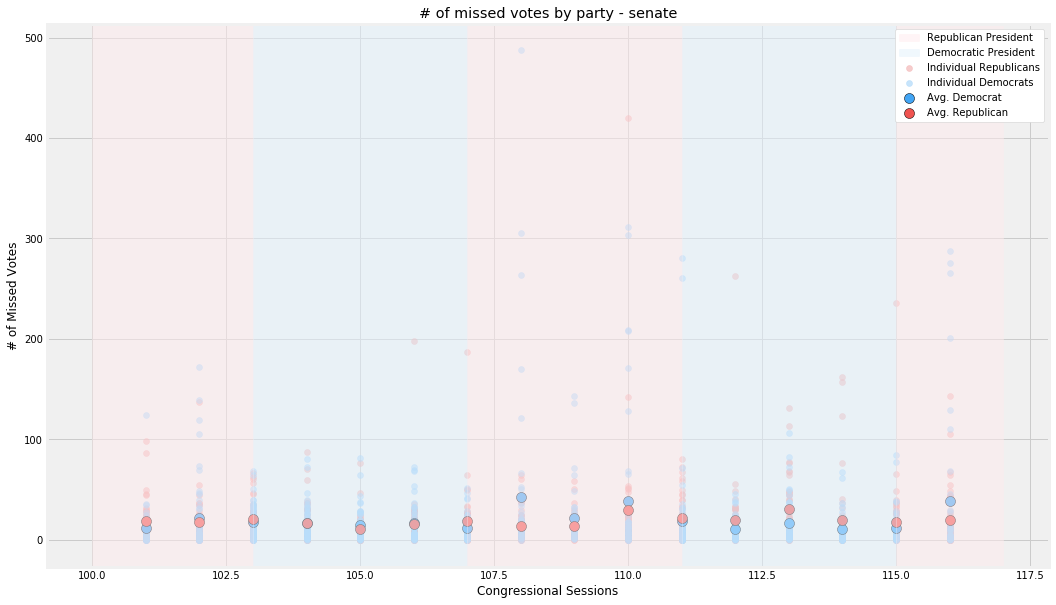

In [32]:
reps_vs_dems('senate', np.mean)

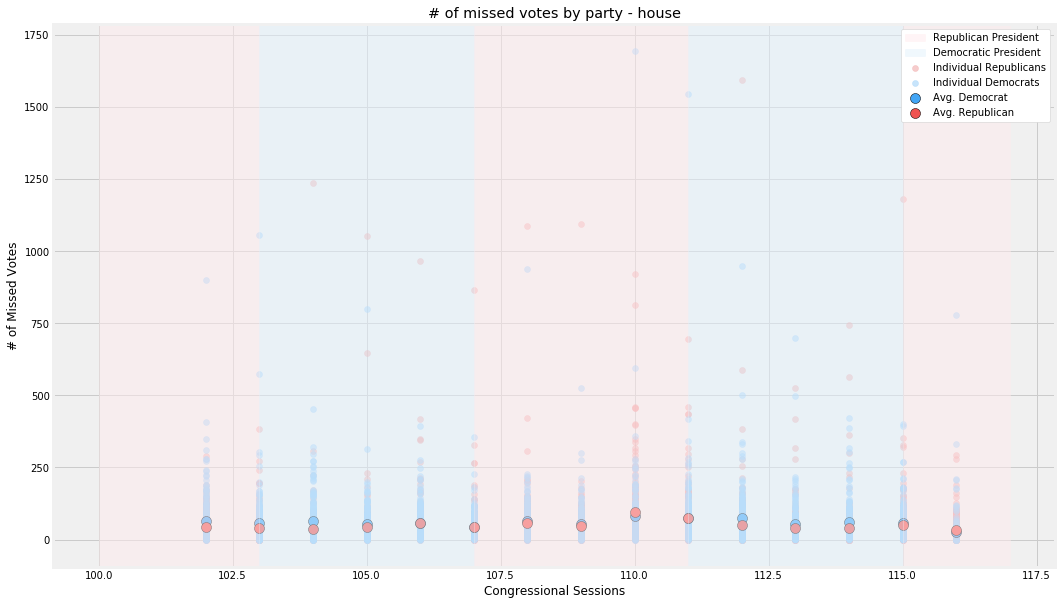

In [33]:
reps_vs_dems('house', np.mean)

### Distance between DC and State/District vs Missed Votes

In [34]:
## following formula here: 
## https://en.wikipedia.org/wiki/Haversine_formula

def get_haversine_distance_from_dc(coord):
    earth_rad = 6371 #earth rad in km
    
    lat_1 = 38.8899 #dc lat in degress north
    long_1 = -77.0091 #dc long in degrees east
    lat_2 = coord.y
    long_2 = coord.x #Need 
    
    
    #haversine = distance between 2 points on a sphere
        
    lat_1 = lat_1 * math.pi/180
    lat_2 = lat_2 * math.pi/180
    
    lat_delta = (lat_2 - lat_1) * math.pi/180
    long_delta = (long_2-long_1) * math.pi/180
    
    a = (pow(math.sin(lat_delta/2), 2) + 
         pow(math.sin(long_delta/2), 2) *
             math.cos(lat_1) * math.cos(lat_2))
    
    c = 2 * math.asin(math.sqrt(a))
    
    d = earth_rad * c #d is distance km
    
    return d

In [35]:
def plot_distance_vs_missed_votes(chamber, congress):
    merged = get_merged_df(chamber=chamber, congress=congress)
    merged['distance_from_dc'] = merged.centroid.apply(get_haversine_distance_from_dc)
    
    distance = merged['distance_from_dc']
    missed = merged['missed_votes']
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.scatter(distance, missed)

    ax.set_xlabel('Distance From Capitol Building (km)')
    ax.set_ylabel('# Of Missed Votes')
    ax.set_title('Distance vs. Missed Votes for the %d %s' % (congress, chamber))
    

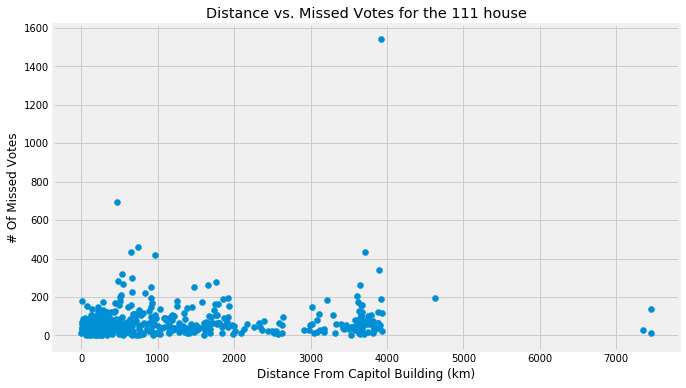

In [36]:
plot_distance_vs_missed_votes('house', 111)

In [37]:
def plot_distance_vs_missed_votes_all_sessions(chamber, lower, upper):
    
    fig, ax = plt.subplots(figsize=(10, 6))

    ax.set_xlabel('Distance From Capitol Building (km)')
    ax.set_ylabel('# Of Missed Votes')
    ax.set_title('Distance vs. Missed Votes for the %s' % (chamber))

    for session in range(lower, upper+1):
        merged = get_merged_df(chamber=chamber, congress=session)
        merged['distance_from_dc'] = merged.centroid.apply(get_haversine_distance_from_dc)
        distance = merged['distance_from_dc']
        missed = merged['missed_votes']
        
        ax.scatter(distance, missed, alpha=0.5, c='#C5E1A5')
        

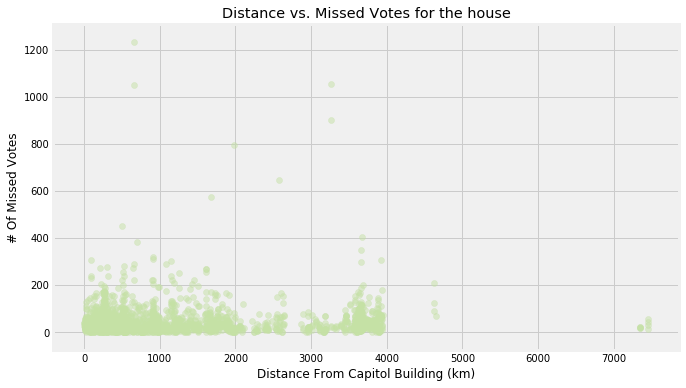

In [38]:
plot_distance_vs_missed_votes_all_sessions('house', lower=102, upper=105)

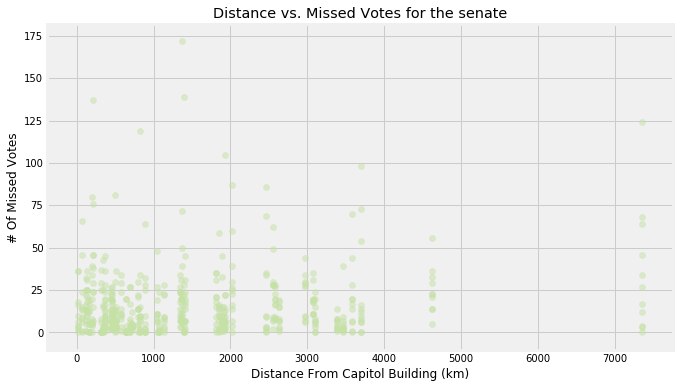

In [39]:
plot_distance_vs_missed_votes_all_sessions('senate', lower=101, upper=105)

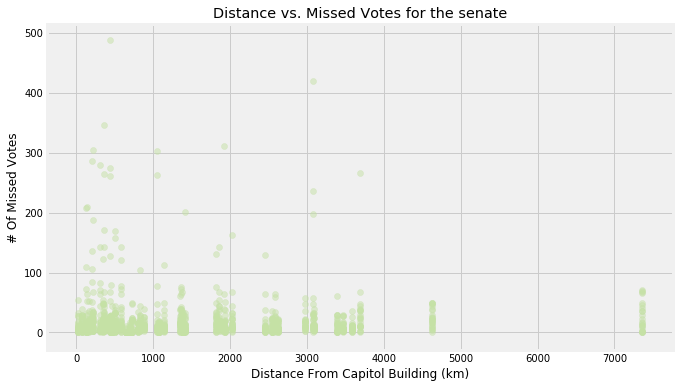

In [40]:
plot_distance_vs_missed_votes_all_sessions('senate', lower=106, upper=116)

In [115]:
merged.columns

Index(['STATEFP', 'STATENS', 'AFFGEOID', 'GEOID', 'STUSPS', 'NAME', 'LSAD',
       'ALAND', 'AWATER', 'geometry', 'STATENAME', 'id', 'first_name',
       'last_name', 'dob', 'gender', 'party', 'leadership_role', 'govtrack_id',
       'cspan_id', 'seniority', 'total_votes', 'missed_votes', 'total_present',
       'state', 'senate_class', 'PCT', 'state_names', 'centroid_lat',
       'centroid_long'],
      dtype='object')